In [1]:
from __future__ import print_function
import sklearn
import sklearn.datasets
import sklearn.ensemble
import pandas as pd
import numpy as np
# import h2o
# from h2o.estimators.random_forest import H2ORandomForestEstimator
# from h2o.estimators.gbm import H2OGradientBoostingEstimator

np.random.seed(1)

import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
import re

%matplotlib inline

In [2]:
input_dir = "../input/"

# Metadata

In [3]:
# usecols = ['ID', 'Label', 'Sub_type', 'PatientID']

usecols = ["sop_instance_uid", "patient_id", "study_instance_uid", "series_instance_uid", "filename"]

#train_metadata = pd.read_csv(input_dir + "stage_1_metadata.csv", usecols = usecols)

train_metadata = pd.read_csv(input_dir + "df_dicom_metadata_train.csv", usecols = usecols)
train_metadata["filename"] = train_metadata["filename"].apply(lambda x: x.split("/")[-1])
train_metadata["set"] = 1
print(train_metadata.shape)
train_metadata.head(3)

(674258, 6)


,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set
0,ID_ff816e9b6,ID_b14d854e,ID_c65a8f2f00,ID_79d2473b55,ID_ff816e9b6.dcm,1
1,ID_282a7f3cd,ID_79cf35b0,ID_9ee24d714d,ID_fe49a86511,ID_282a7f3cd.dcm,1
2,ID_f1c65b76e,ID_43dd2890,ID_43af13416f,ID_143018582f,ID_f1c65b76e.dcm,1


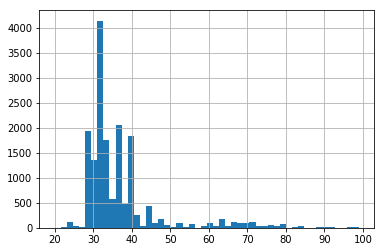

In [4]:
tmp = train_metadata["patient_id"].value_counts()
tmp[tmp<100].hist(bins=50);

In [5]:
test_metadata = pd.read_csv(input_dir + "df_dicom_metadata_test.csv", usecols = usecols)
test_metadata["filename"] = train_metadata["filename"].apply(lambda x: x.split("/")[-1])
test_metadata["set"] = 0
print(test_metadata.shape)
test_metadata.head(3)

(78545, 6)


,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set
0,ID_cec48be98,ID_02159492,ID_6d53e6b7a1,ID_8a81168925,ID_ff816e9b6.dcm,0
1,ID_24499006f,ID_d11a0081,ID_816f37dbe8,ID_d06566b389,ID_282a7f3cd.dcm,0
2,ID_398dc0001,ID_c4cc9737,ID_5f64ee7147,ID_ffa52dd6f4,ID_f1c65b76e.dcm,0


In [6]:
patient_id_train = set(train_metadata["patient_id"].unique())
patient_id_test = set(test_metadata["patient_id"].unique())
print(len(patient_id_train), len(patient_id_test))

17079 2144


In [7]:
patient_id_dup = patient_id_train.intersection(patient_id_test)
len(patient_id_dup)

285

# Split

In [8]:
df = pd.read_csv("../input/stage_1_train.csv")
print(df.shape)
df.head(3)

(4045572, 2)


,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0


In [9]:
df = df.drop_duplicates(subset='ID', keep="first")
print(df.shape)

(4045548, 2)


In [10]:
df["sop_instance_uid"] = df["ID"].apply(lambda x: "ID_" + x.split('_')[1])
df["SubType"] = df['ID'].apply(lambda x: x.split('_')[2])
df.tail(3)

,ID,Label,sop_instance_uid,SubType
4045569,ID_5c8b5d701_subarachnoid,1,ID_5c8b5d701,subarachnoid
4045570,ID_5c8b5d701_subdural,1,ID_5c8b5d701,subdural
4045571,ID_5c8b5d701_any,1,ID_5c8b5d701,any


In [11]:
IGNORE_IDS = ['ID_6431af929']
print(df.shape)
df = df[~df['sop_instance_uid'].isin(IGNORE_IDS)]
print(df.shape)

(4045548, 4)
(4045542, 4)


In [12]:
df_dup = df.groupby(['sop_instance_uid'], as_index=False).agg({"Label": ["sum", "count"]})
df_dup.columns = ["sop_instance_uid", "sum", "count"]
df_dup.head(3)

,sop_instance_uid,sum,count
0,ID_000039fa0,0,6
1,ID_00005679d,0,6
2,ID_00008ce3c,0,6


In [13]:
dup_images = list(df_dup[df_dup["count"] > 6]["sop_instance_uid"])
print(len(dup_images))
df[df["sop_instance_uid"].isin(dup_images)]

0


,ID,Label,sop_instance_uid,SubType


In [14]:
df = df.pivot(index='sop_instance_uid', columns='SubType', values='Label').reset_index()
print(df.shape)
df.head(3)

(674257, 7)


SubType,sop_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0


In [15]:
df = pd.merge(df, train_metadata[["sop_instance_uid", "patient_id"]])

In [21]:
output_dir = "../csv/"

In [17]:
!mkdir -p $output_dir

# Splits
TODO - StratifiedKFold based on labels

In [18]:
patient_id = patient_id_train.difference(patient_id_test)
print(len(patient_id_train), len(patient_id))

patient_id = np.array(list(patient_id))

17079 16794


In [19]:
from sklearn.model_selection import KFold

seed = 2020
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed) # StratifiedKFold

fold = 0
for train_index, valid_index in kf.split(patient_id):
    df_train = df[df["patient_id"].isin(patient_id[train_index])]
    df_valid = df[df["patient_id"].isin(patient_id[valid_index])]
    
    df_train.to_csv(output_dir + "train_{}.csv".format(fold), index=None)
    df_valid.to_csv(output_dir + "valid_{}.csv".format(fold), index=None)
    
    fold += 1
    print(df_valid.shape)

(131308, 8)
(130796, 8)
(131887, 8)
(131887, 8)
(131825, 8)


In [20]:
!head -3 $output_dir/train_0.csv

sop_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id
ID_000039fa0,0,0,0,0,0,0,ID_eeaf99e7
ID_00005679d,0,0,0,0,0,0,ID_18f2d431


# Test set

In [14]:
df_test = pd.read_csv("../input/stage_1_sample_submission.csv")
print(df_test.shape)
df_test.head(3)

(471270, 2)


,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5


In [15]:
df_test = df_test.drop_duplicates(subset='ID', keep="first")
print(df_test.shape)

(471270, 2)


In [16]:
test_metadata = pd.read_csv(input_dir + "df_dicom_metadata_test.csv", usecols = usecols)
test_metadata["filename"] = test_metadata["filename"].apply(lambda x: x.split("/")[-1])
test_metadata["set"] = 0
print(test_metadata.shape)
test_metadata.head(3)

(78545, 6)


,sop_instance_uid,patient_id,study_instance_uid,series_instance_uid,filename,set
0,ID_cec48be98,ID_02159492,ID_6d53e6b7a1,ID_8a81168925,ID_cec48be98.dcm,0
1,ID_24499006f,ID_d11a0081,ID_816f37dbe8,ID_d06566b389,ID_24499006f.dcm,0
2,ID_398dc0001,ID_c4cc9737,ID_5f64ee7147,ID_ffa52dd6f4,ID_398dc0001.dcm,0


In [17]:
df_test["sop_instance_uid"] = df_test["ID"].apply(lambda x: "ID_" + x.split('_')[1])
df_test["SubType"] = df_test['ID'].apply(lambda x: x.split('_')[2])
df_test.tail(3)

,ID,Label,sop_instance_uid,SubType
471267,ID_d47269109_subarachnoid,0.5,ID_d47269109,subarachnoid
471268,ID_d47269109_subdural,0.5,ID_d47269109,subdural
471269,ID_d47269109_any,0.5,ID_d47269109,any


In [18]:
df_test = df_test.pivot(index='sop_instance_uid', columns='SubType', values='Label').reset_index()
print(df_test.shape)
df_test.head(3)

(78545, 7)


SubType,sop_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_0000ca2f6,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_000259ccf,0.5,0.5,0.5,0.5,0.5,0.5


In [19]:
df_test = pd.merge(df_test, test_metadata[["sop_instance_uid", "patient_id"]])
df_test.head(3)

,sop_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id
0,ID_000012eaf,0.5,0.5,0.5,0.5,0.5,0.5,ID_f15c0eee
1,ID_0000ca2f6,0.5,0.5,0.5,0.5,0.5,0.5,ID_8c5a14af
2,ID_000259ccf,0.5,0.5,0.5,0.5,0.5,0.5,ID_ee4d05e4


In [22]:
df_test.to_csv(output_dir + "test.csv", index=None)
output_dir + "test.csv"

'../csv/test.csv'

# Play

In [28]:
df[df["patient_id"].isin(patient_id)].shape, df.shape, len(patient_id_dup)

((657703, 8), (674257, 8), 285)

In [29]:
674257 - 657703, (674257 - 657703) / 285

(16554, 58.084210526315786)